In [19]:
import toml
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import colorcet as cc
import matplotlib.pyplot as plt

from scipy import signal
from os.path import join
from tqdm.auto import tqdm
from collections import defaultdict
from rl_analysis.behavior.moseq import syll_onset
from rl_analysis.io.df import NONSYLL_COLS, dlight_exclude_toml, load_dlight_features
from rl_analysis.photometry.windowing import window_trials_as_mtx
from rl_analysis.plotting import save_factory, setup_plotting_env, fg, clean_ticks

warnings.simplefilter('ignore')

In [2]:
def dlight_filter(ser):
    soscoeffs = signal.bessel(1, 1 / (30 / 2.), btype="high", output="sos")
    sig = ser.dropna()
    new_ser = pd.Series(index=ser.index)
    new_ser.loc[sig.index] = signal.sosfiltfilt(soscoeffs, sig)
    return new_ser

In [3]:
with open("../analysis_configuration.toml", "r") as f:
    config = toml.load(f)

In [4]:
setup_plotting_env()

saver = save_factory(join(config['figures']['store_dir'], 'variability-fig'), tight_layout=False)

plt.rcParams['figure.dpi'] = 300


dlight_key = "dlight filtered"

In [5]:
use_dct = dlight_exclude_toml(
    join(config['raw_data']['dlight'], 'dlight_photometry_processed_full.toml'),
    **config["dlight_common"]
)

In [6]:
df = pd.read_parquet(
    join(config['raw_data']['dlight'], 'dlight_photometry_processed_full.parquet'),
    filters=[("uuid", "in", list(use_dct)), ("area", "=", "dls")],
)

df = df[~df["session_number"].isin([3, 4])]
df = df.drop(columns=NONSYLL_COLS)
df = df.sort_index()

df["offline onset"] = False
df.loc[df.index[syll_onset(df["predicted_syllable (offline)"])], "offline onset"] = True
df[dlight_key] = df.groupby("uuid", sort=False, observed=True)[
    "signal_reref_dff_z"
].transform(dlight_filter)

In [7]:
sorting = joblib.load(join(config['intermediate_results']['dlight'], 'fig1-syllable-sorting.p'))

In [8]:
time_window = (-1.5, 1.5)

In [9]:
feat_df = load_dlight_features('/home/wg41/reinforcement_data/public-dataset/dlight-chrimson_snippets_offline_features.parquet')
feat_df = feat_df[feat_df['uuid'].isin(use_dct)]

## Plot heatmap of mouse and syllable sorted dLight waveforms

In [10]:
waveforms = defaultdict(list)
peaks = defaultdict(list)

for k, _df in tqdm(df.groupby(['mouse_id', 'uuid'], sort=False, observed=True)):
    feat_session = feat_df[feat_df['uuid'] == k[1]]
    for syll in sorting:
        inds = np.where((_df['predicted_syllable (offline)'] == syll) & _df['offline onset'])[0]
        if len(inds) > 0:
            time, mtx = window_trials_as_mtx(_df, inds, dlight_key, truncation_window=time_window)
            waveforms[syll].append(np.nanmean(mtx, axis=0))
            # grab avg peak DA
            _avg_peak_da = feat_session.loc[feat_session['syllable'] == syll, 'signal_reref_dff_z_max'].mean()
            peaks[syll].append(_avg_peak_da)
waveforms = dict(waveforms)
peaks = dict(peaks)

  0%|          | 0/216 [00:00<?, ?it/s]

In [11]:
all_peaks = np.concatenate([peaks[k] for k in sorting])

everything = np.concatenate([waveforms[k] for k in sorting], axis=0)
mask = np.all(np.isnan(everything), axis=1)

# show re-ordered syll labels
syll_labels = []
for k in sorting:
    syll_labels.extend(np.repeat([sorting[k]], len(waveforms[k])))
syll_labels = np.array(syll_labels)

everything = everything[~mask]
syll_labels = syll_labels[~mask]
all_peaks = all_peaks[~mask]

cumulative = pd.Series(syll_labels).value_counts().reindex(sorting.values())
boundaries = cumulative.cumsum()

In [12]:
sylls, counts = np.unique(syll_labels, return_counts=True)

offset = counts[0] // 2

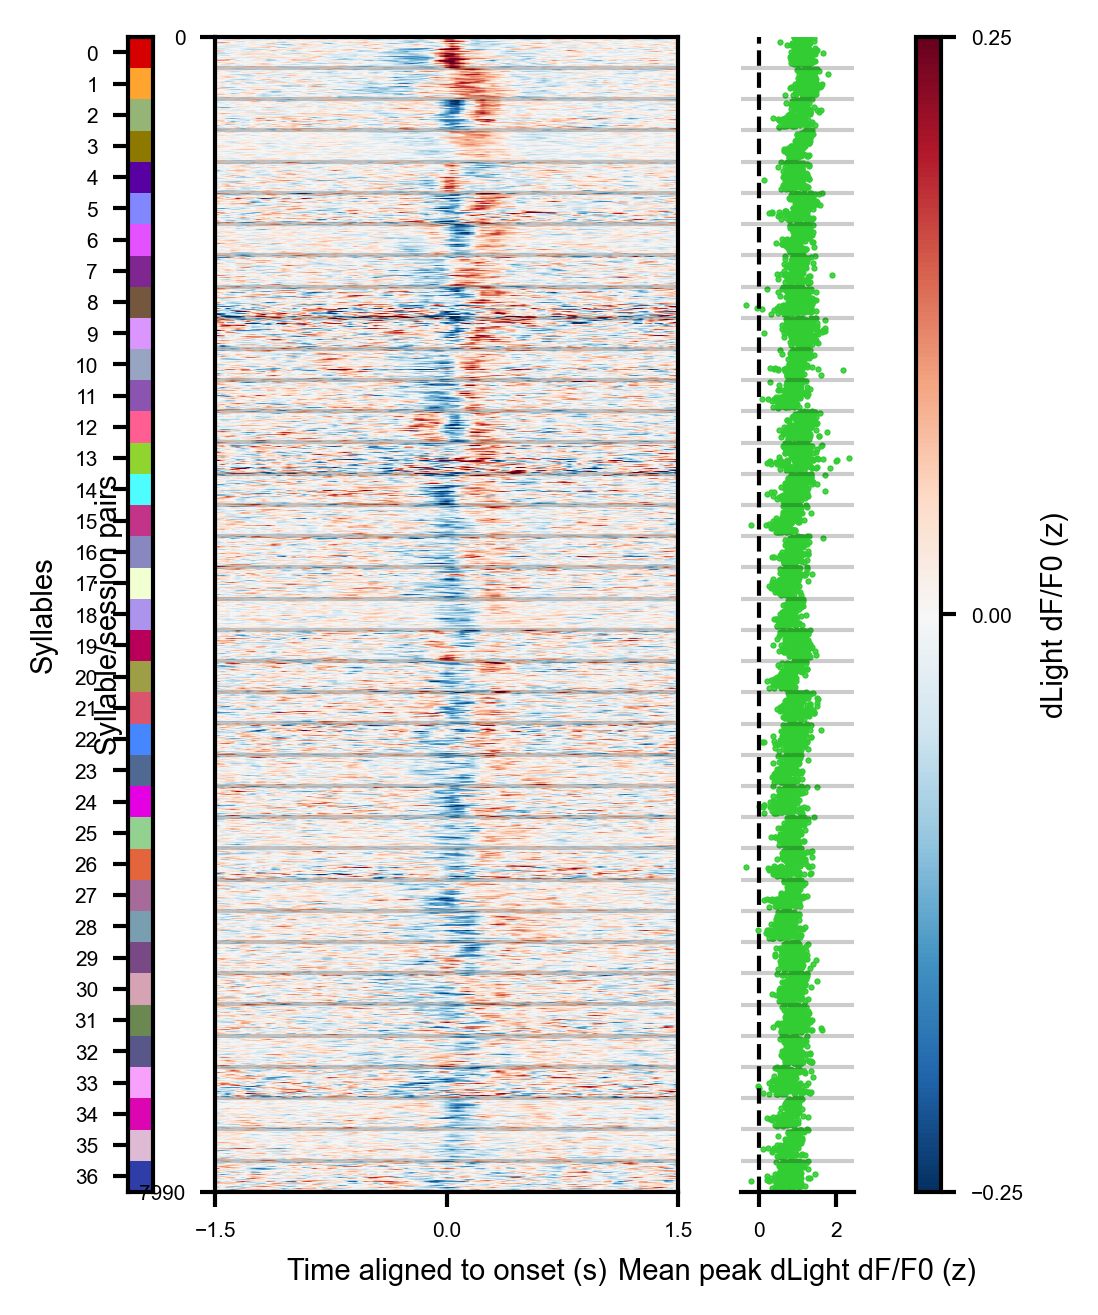

In [13]:
color_range = 0.25
fig, ax_dict = plt.subplot_mosaic(
    "ABBBBBBCCD",
    figsize=(3.5, 5),
)
fig.dpi = 150
ax_dict["A"].imshow(
    syll_labels[:, None],
    aspect="auto",
    cmap=cc.cm.glasbey,
    extent=(0, 1, len(everything) - 0.5, 0.5),
    interpolation="none", 
)
ax_dict["A"].set(
    xticks=[],
    ylabel="Syllables",
    yticks=np.linspace(offset, len(syll_labels) - offset, len(sorting)),
    yticklabels=sorting.values(),
)
im = ax_dict["B"].imshow(
    everything,
    aspect="auto",
    cmap="RdBu_r",
    vmin=-color_range,
    vmax=color_range,
    extent=(time[0], time[-1], len(everything), 0),
)
ax_dict["B"].set(
    xlabel="Time aligned to onset (s)",
    ylabel="Syllable/session pairs",
    yticks=[0.5, len(everything) - 0.5],
    xticks=[time[0], 0, time[-1]],
)
for _, v in boundaries.iteritems():
    ax_dict["B"].axhline(v, lw=1, ls="-", c="k", alpha=0.2)
ax_dict["C"].plot(all_peaks, np.arange(len(all_peaks)), ".", c="limegreen", ms=1)
ax_dict["C"].axvline(0, lw=1, ls="--", c="k")
ax_dict["C"].set(ylim=(0, len(all_peaks) - 1), yticks=[], xlabel="Mean peak dLight dF/F0 (z)")
ax_dict["C"].invert_yaxis()
for _, v in boundaries.iteritems():
    ax_dict["C"].axhline(v, lw=1, ls="-", c="k", alpha=0.2)
# clean_ticks(ax_dict['C'], zero_symmetry=False, precision=1)
sns.despine(ax=ax_dict["C"], left=True)

cb = fig.colorbar(im, cax=ax_dict["D"], label="dLight dF/F0 (z)", aspect=60)
cb.set_ticks([-color_range, 0, color_range])
plt.subplots_adjust(wspace=2.5)

saver(fig, "avg-filtered-dlight-waveforms-for-all-syllables-and-sessions");

## Breakout some syllables

In [14]:
breakouts = np.array(list(sorting))[[1, 12, -3]]
breakouts

array([ 5, 86, 25])

In [21]:
waveforms = defaultdict(list)
peaks = defaultdict(list)

for k, _df in tqdm(df.groupby('mouse_id', sort=False, observed=True)):
    feat_session = feat_df[feat_df['mouse_id'] == k]
    for syll in breakouts:
        inds = np.where((_df['predicted_syllable (offline)'] == syll) & _df['offline onset'])[0]
        if len(inds) > 0:
            time, mtx = window_trials_as_mtx(_df, inds, dlight_key, truncation_window=time_window)
            waveforms[syll].append(np.nanmean(mtx, axis=0))
            # grab avg peak DA
            _avg_peak_da = feat_session.loc[feat_session['syllable'] == syll, 'signal_reref_dff_z_max'].mean()
            peaks[syll].append(_avg_peak_da)
waveforms = dict(waveforms)
peaks = dict(peaks)

  0%|          | 0/14 [00:00<?, ?it/s]

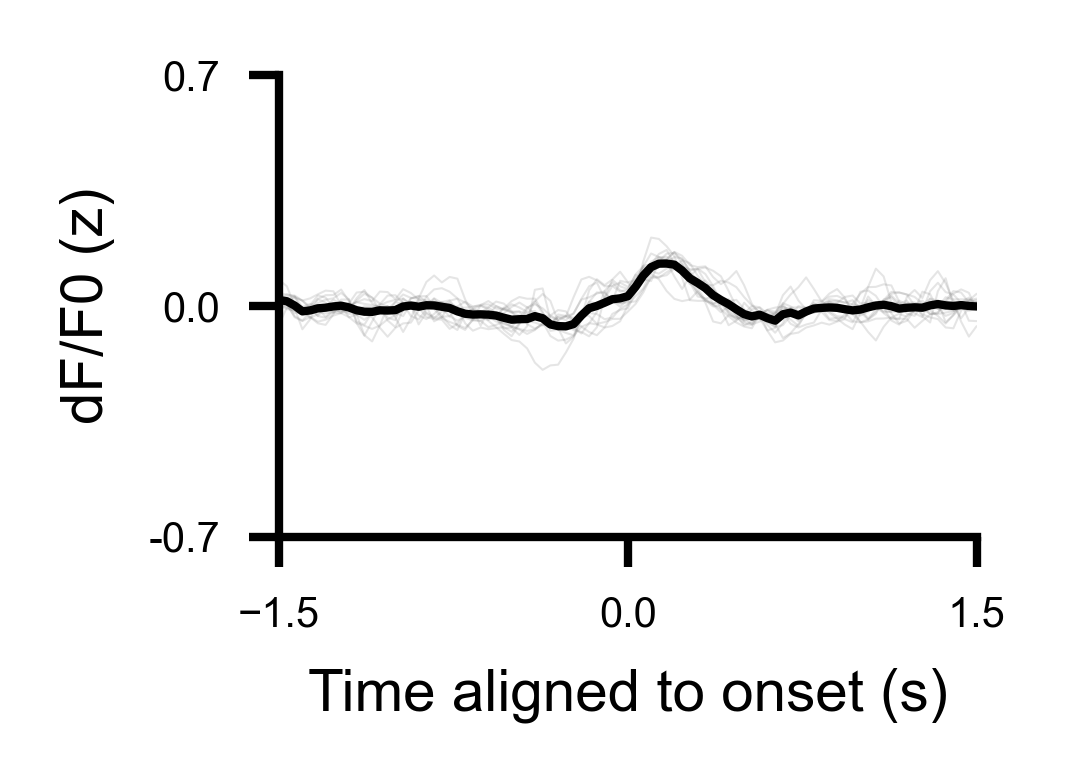

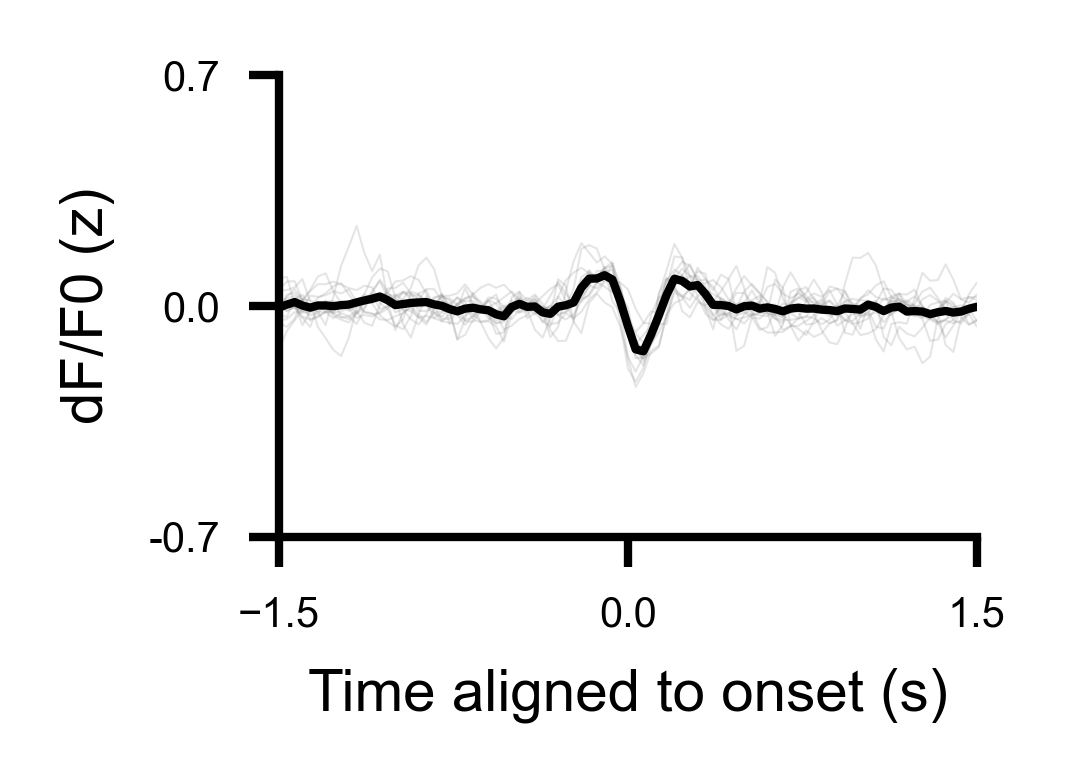

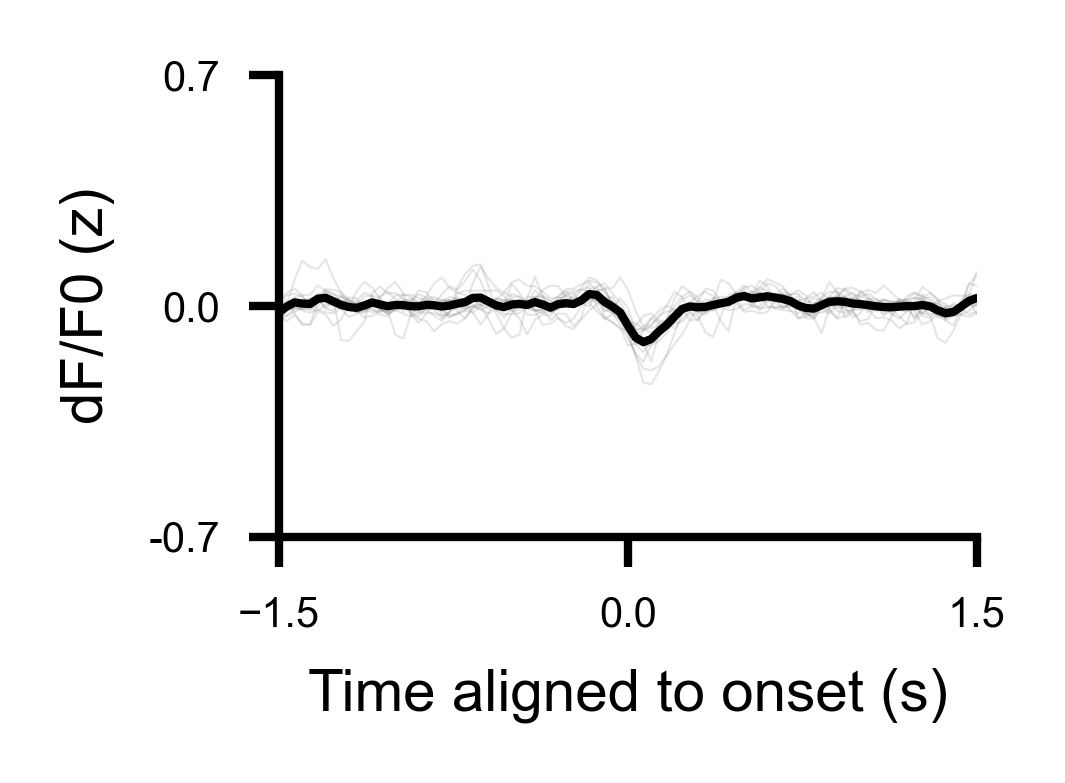

In [22]:
for k, v in waveforms.items():
    fig = fg(1.5, 1)
    fig.dpi = 300
    ax = fig.gca()
    ax.plot(time, np.array(v).T, lw=0.25, c="gray", alpha=0.2)
    ax.plot(time, np.nanmean(v, axis=0), lw=1, c="k")
    ax.set(
        xlim=time_window,
        xlabel="Time aligned to onset (s)",
        ylabel="dF/F0 (z)",
        xticks=(time_window[0], 0, time_window[1]),
        ylim=(-0.7, 0.7),
    )
    clean_ticks(ax, axis="y", zero_symmetry=False)
    sns.despine()
    saver(fig, f"filtered-syllable-callout-{k}-per-session");